In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
import torch
import numpy as np

/home/ichuviliaeva/miniconda3/envs/hw_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import abbyy_course_cvdl_t2

In [4]:
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [5]:
import abbyy_course_cvdl_t2
TINY_COCO_BASE = Path(abbyy_course_cvdl_t2.__file__).parent.parent / 'data'
TINY_COCO_BASE.exists()

True

In [6]:
from torchvision.datasets import CocoDetection

Если CocoDetection падает, вероятно, вам нужно установить pycocotools: `pip install pycocotools`

Раньше pycocotools требовал предварительную установки cython:
`pip install cython`
Раньше установка на windows работала криво: https://stackoverflow.com/questions/52920222/could-not-install-pycocotools-in-windows-fatal-error-c1083-cannot-open-include

На новых версиях python на windows теперь работает ок.

In [7]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [8]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection

In [9]:
ds_text = CocoTextDetection(
    Path("/DATA/ichuviliaeva/coco_kaggle/train2014/train2014"),
    Path("/DATA/ichuviliaeva/coco_kaggle/cocotext.v2/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(256,256), ids_map = {1: 0, 0:0}
),
    area_fraction_threshold=1/32/32
)

In [10]:
x, y = ds_text[6]

In [11]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


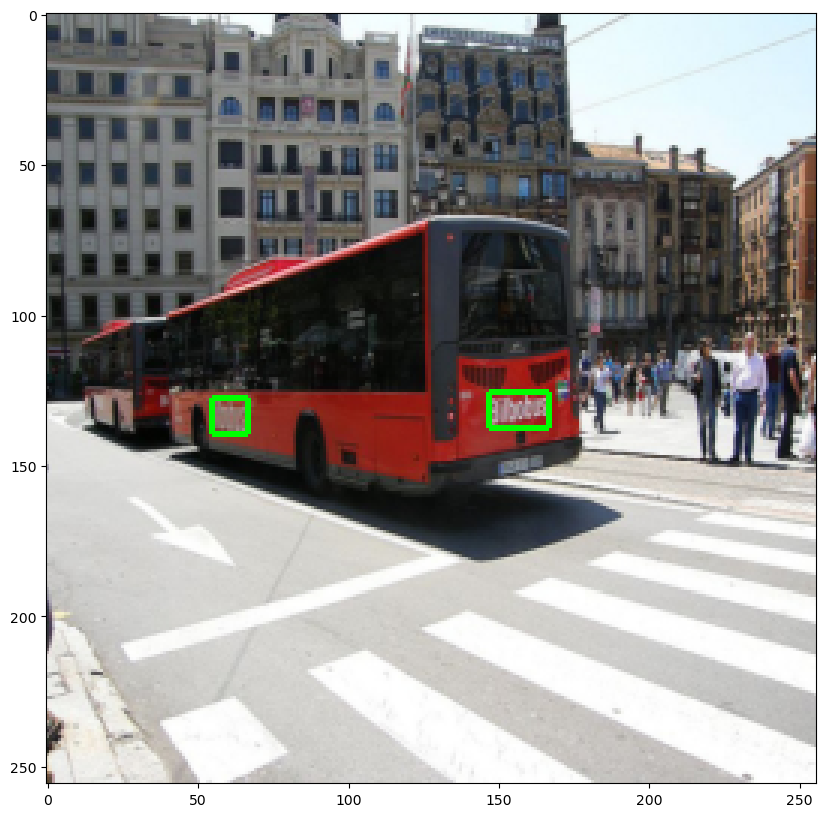

In [12]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [13]:
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss


In [14]:
net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=1))

In [15]:
net = train(ds_text, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device('cuda:0'), lr=1e-3)

/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(objects[:, :, 2]).to(objects.device)
/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(objects[:, :, 3]).to(objects.device)


epoch 0|0; total loss:50.2324333190918
last losses: [1506.2716064453125, 0.23251433670520782, 0.4687725901603699]
epoch 0|30; total loss:57.24127197265625
last losses: [0.00011143546726088971, 0.24215763807296753, 0.23770612478256226]
epoch 0|60; total loss:0.5062149167060852
last losses: [3.7250847526593134e-05, 0.25289076566696167, 0.3225014805793762]
epoch 0|90; total loss:0.5079832077026367
last losses: [3.8558664527954534e-05, 0.24531759321689606, 0.24413245916366577]
epoch 0|120; total loss:0.4937063157558441
last losses: [3.7198835343588144e-05, 0.26774242520332336, 0.30350926518440247]
epoch 0|150; total loss:0.5013647675514221
last losses: [4.2798004869837314e-05, 0.2571954131126404, 0.253013551235199]
epoch 0|180; total loss:0.506568968296051
last losses: [5.663066258421168e-05, 0.20064611732959747, 0.20207588374614716]
epoch 0|210; total loss:0.4935671091079712
last losses: [5.191375385038555e-05, 0.2495933473110199, 0.3097437620162964]
epoch 0|240; total loss:0.497569590806

epoch 6|240; total loss:0.4340879023075104
last losses: [7.154015474952757e-05, 0.22521159052848816, 0.14149898290634155]
epoch 6|270; total loss:0.4476724863052368
last losses: [8.12200887594372e-05, 0.28760403394699097, 0.2469518482685089]
epoch 7|0; total loss:0.016174379736185074
last losses: [0.00012027095363009721, 0.2616441547870636, 0.2234669178724289]
epoch 7|30; total loss:0.4204482436180115
last losses: [0.00010612931509967893, 0.22399207949638367, 0.13914531469345093]
epoch 7|60; total loss:0.4213641583919525
last losses: [9.162432979792356e-05, 0.273512601852417, 0.19076643884181976]
epoch 7|90; total loss:0.41259902715682983
last losses: [0.00010628194286255166, 0.2125476747751236, 0.15399612486362457]
epoch 7|120; total loss:0.4093862473964691
last losses: [0.00016736188263166696, 0.19825930893421173, 0.14447875320911407]
epoch 7|150; total loss:0.42622679471969604
last losses: [9.597650932846591e-05, 0.24667030572891235, 0.15472212433815002]
epoch 7|180; total loss:0.41

epoch 13|180; total loss:0.3599654734134674
last losses: [5.5953765695448965e-05, 0.24429143965244293, 0.10196109861135483]
epoch 13|210; total loss:0.34855011105537415
last losses: [7.453595026163384e-05, 0.25124049186706543, 0.12624257802963257]
epoch 13|240; total loss:0.36576715111732483
last losses: [8.331035496667027e-05, 0.22229185700416565, 0.09085752069950104]
epoch 13|270; total loss:0.3693743348121643
last losses: [6.440268771257252e-05, 0.23102682828903198, 0.12033148854970932]
epoch 14|0; total loss:0.013094335794448853
last losses: [0.00010776073031593114, 0.27057623863220215, 0.12214604020118713]
epoch 14|30; total loss:0.34862059354782104
last losses: [6.942459003766999e-05, 0.2330026924610138, 0.0971226692199707]
epoch 14|60; total loss:0.3427877724170685
last losses: [5.4986881877994165e-05, 0.24584217369556427, 0.10361568629741669]
epoch 14|90; total loss:0.3532833456993103
last losses: [7.205738802440464e-05, 0.24560196697711945, 0.09173525124788284]
epoch 14|120; t

epoch 20|90; total loss:0.3271046578884125
last losses: [6.61597223370336e-05, 0.2552502155303955, 0.11443328112363815]
epoch 20|120; total loss:0.3183768391609192
last losses: [8.363319648196921e-05, 0.18911322951316833, 0.06435689330101013]
epoch 20|150; total loss:0.33483782410621643
last losses: [9.205716196447611e-05, 0.26327642798423767, 0.09162604808807373]
epoch 20|180; total loss:0.3252502381801605
last losses: [7.698088302277029e-05, 0.224863201379776, 0.07478602230548859]
epoch 20|210; total loss:0.3317030072212219
last losses: [5.8483688917476684e-05, 0.2703590989112854, 0.11731914430856705]
epoch 20|240; total loss:0.3244178295135498
last losses: [8.637185237603262e-05, 0.21154630184173584, 0.08192036300897598]
epoch 20|270; total loss:0.32642418146133423
last losses: [7.776408892823383e-05, 0.21464911103248596, 0.08854829519987106]
epoch 21|0; total loss:0.011518221348524094
last losses: [6.390493945218623e-05, 0.24621015787124634, 0.09927257895469666]
epoch 21|30; total 

epoch 27|0; total loss:0.00933475699275732
last losses: [3.0829422030365095e-05, 0.19934049248695374, 0.08067138493061066]
epoch 27|30; total loss:0.2782399654388428
last losses: [2.7845877411891706e-05, 0.21137142181396484, 0.10372806340456009]
epoch 27|60; total loss:0.2788117229938507
last losses: [2.155686161131598e-05, 0.20881599187850952, 0.08846300840377808]
epoch 27|90; total loss:0.28944939374923706
last losses: [3.242349703214131e-05, 0.2420249879360199, 0.07906456291675568]
epoch 27|120; total loss:0.2701658606529236
last losses: [4.247858305461705e-05, 0.19540061056613922, 0.05022208392620087]
epoch 27|150; total loss:0.2794637084007263
last losses: [3.354587533976883e-05, 0.20267610251903534, 0.08526064455509186]
epoch 27|180; total loss:0.2814115285873413
last losses: [2.824974581017159e-05, 0.21081022918224335, 0.07426172494888306]
epoch 27|210; total loss:0.27460044622421265
last losses: [1.904057717183605e-05, 0.22516420483589172, 0.08301015198230743]
epoch 27|240; tot

epoch 33|210; total loss:0.24034596979618073
last losses: [1.3906748790759593e-05, 0.1800343543291092, 0.0624205619096756]
epoch 33|240; total loss:0.24935904145240784
last losses: [1.706877810647711e-05, 0.20007292926311493, 0.06885115802288055]
epoch 33|270; total loss:0.23962153494358063
last losses: [2.2737571271136403e-05, 0.14651183784008026, 0.04973714053630829]
epoch 34|0; total loss:0.007586606312543154
last losses: [2.0908079022774473e-05, 0.16544237732887268, 0.06213489547371864]
epoch 34|30; total loss:0.24869561195373535
last losses: [1.7172782463603653e-05, 0.205705463886261, 0.07998660206794739]
epoch 34|60; total loss:0.24175876379013062
last losses: [1.6087356925709173e-05, 0.17821423709392548, 0.062485937029123306]
epoch 34|90; total loss:0.2391868233680725
last losses: [1.3504157323041e-05, 0.19792790710926056, 0.07938340306282043]
epoch 34|120; total loss:0.243243008852005
last losses: [2.4608332751085982e-05, 0.1609259992837906, 0.05635184794664383]
epoch 34|150; t

epoch 40|120; total loss:0.21375541388988495
last losses: [7.400258255074732e-06, 0.18524888157844543, 0.06644533574581146]
epoch 40|150; total loss:0.22109432518482208
last losses: [5.509464244823903e-06, 0.14923204481601715, 0.047808386385440826]
epoch 40|180; total loss:0.21566864848136902
last losses: [8.586702278989833e-06, 0.15364810824394226, 0.04383569955825806]
epoch 40|210; total loss:0.2108534276485443
last losses: [8.603897185821552e-06, 0.1314416378736496, 0.040356360375881195]
epoch 40|240; total loss:0.2170746773481369
last losses: [7.850686415622476e-06, 0.16334961354732513, 0.06111118197441101]
epoch 40|270; total loss:0.22049684822559357
last losses: [8.943974535213783e-06, 0.1664266735315323, 0.057895418256521225]
epoch 41|0; total loss:0.007636975031346083
last losses: [7.1372032834915444e-06, 0.17221879959106445, 0.056883305311203]
epoch 41|30; total loss:0.223443403840065
last losses: [4.276838808436878e-06, 0.20127446949481964, 0.0620611235499382]
epoch 41|60; to

epoch 47|30; total loss:0.1894400715827942
last losses: [2.170904053855338e-06, 0.1449321061372757, 0.061154551804065704]
epoch 47|60; total loss:0.1896984875202179
last losses: [1.4167658264341298e-06, 0.1101398840546608, 0.04068029671907425]
epoch 47|90; total loss:0.18470263481140137
last losses: [1.946364136529155e-06, 0.14488334953784943, 0.05382228270173073]
epoch 47|120; total loss:0.18056699633598328
last losses: [1.8681791971175699e-06, 0.11122837662696838, 0.032537929713726044]
epoch 47|150; total loss:0.17839285731315613
last losses: [2.316774725841242e-06, 0.13307060301303864, 0.04450158029794693]
epoch 47|180; total loss:0.18811415135860443
last losses: [2.71743192570284e-06, 0.13525018095970154, 0.053107086569070816]
epoch 47|210; total loss:0.1776493489742279
last losses: [2.6562831862975145e-06, 0.12770676612854004, 0.055289700627326965]
epoch 47|240; total loss:0.18502795696258545
last losses: [2.3720003810012713e-06, 0.13453629612922668, 0.055592723190784454]
epoch 47

epoch 53|240; total loss:0.15340307354927063
last losses: [3.365231009411218e-07, 0.08589790761470795, 0.04660046100616455]
epoch 53|270; total loss:0.1500355750322342
last losses: [3.2408456718258094e-07, 0.10153399407863617, 0.041699767112731934]
epoch 54|0; total loss:0.005706403404474258
last losses: [5.295016762829619e-07, 0.1254592388868332, 0.04573232680559158]
epoch 54|30; total loss:0.15073223412036896
last losses: [4.4287548917054664e-07, 0.11437144875526428, 0.05121203511953354]
epoch 54|60; total loss:0.15237094461917877
last losses: [4.4875511662212375e-07, 0.10958307981491089, 0.04368675500154495]
epoch 54|90; total loss:0.1532406061887741
last losses: [2.934776546226203e-07, 0.09966419637203217, 0.045925796031951904]
epoch 54|120; total loss:0.15793316066265106
last losses: [3.0763055747229373e-07, 0.10583935678005219, 0.0463639572262764]
epoch 54|150; total loss:0.15603896975517273
last losses: [2.512650780772674e-07, 0.12283718585968018, 0.043706122785806656]
epoch 54|

epoch 60|150; total loss:0.12341958284378052
last losses: [1.4441441464896343e-07, 0.08157314360141754, 0.03457563370466232]
epoch 60|180; total loss:0.12936867773532867
last losses: [1.258008950344447e-07, 0.09803459793329239, 0.04010375216603279]
epoch 60|210; total loss:0.12782150506973267
last losses: [1.568734262491489e-07, 0.06623764336109161, 0.03246461972594261]
epoch 60|240; total loss:0.1275358945131302
last losses: [9.906061393394339e-08, 0.08594939112663269, 0.040264878422021866]
epoch 60|270; total loss:0.12926742434501648
last losses: [1.6803595315195707e-07, 0.10295405238866806, 0.04463034123182297]
epoch 61|0; total loss:0.00453013414517045
last losses: [1.4449649654579844e-07, 0.09310413897037506, 0.04279973730444908]
epoch 61|30; total loss:0.13970397412776947
last losses: [6.066027680162733e-08, 0.0973784327507019, 0.04586246609687805]
epoch 61|60; total loss:0.12823748588562012
last losses: [7.429976278672257e-08, 0.0711325854063034, 0.031500641256570816]
epoch 61|9

epoch 67|60; total loss:0.104954794049263
last losses: [3.221097699679376e-08, 0.06646718084812164, 0.0375041663646698]
epoch 67|90; total loss:0.10327226668596268
last losses: [3.083894029032308e-08, 0.059114545583724976, 0.03261062875390053]
epoch 67|120; total loss:0.10309537500143051
last losses: [3.308528917500553e-08, 0.07142170518636703, 0.032166965305805206]
epoch 67|150; total loss:0.10317057371139526
last losses: [2.989619929394394e-08, 0.05378466472029686, 0.023521289229393005]
epoch 67|180; total loss:0.10429584980010986
last losses: [2.5329292441256257e-08, 0.08108972012996674, 0.041959960013628006]
epoch 67|210; total loss:0.10364590585231781
last losses: [2.952454103422042e-08, 0.07524330914020538, 0.036825377494096756]
epoch 67|240; total loss:0.09842664748430252
last losses: [1.7820759978803835e-08, 0.08365048468112946, 0.04248917102813721]
epoch 67|270; total loss:0.10239600390195847
last losses: [1.9475603352248072e-08, 0.07668547332286835, 0.040818262845277786]
epoc

epoch 73|240; total loss:0.08496333658695221
last losses: [9.162684833086132e-09, 0.05239526554942131, 0.02943231910467148]
epoch 73|270; total loss:0.09050839394330978
last losses: [1.456391807153068e-08, 0.04957736283540726, 0.03211595490574837]
epoch 74|0; total loss:0.0027375847566872835
last losses: [1.0574254361017665e-08, 0.05023089796304703, 0.03189662843942642]
epoch 74|30; total loss:0.08814677596092224
last losses: [6.9201542274299754e-09, 0.04975534975528717, 0.02453497424721718]
epoch 74|60; total loss:0.08731868863105774
last losses: [1.1823309442604568e-08, 0.054299261420965195, 0.027857864275574684]
epoch 74|90; total loss:0.08458489179611206
last losses: [1.1566850588451416e-08, 0.04064135253429413, 0.02413209155201912]
epoch 74|120; total loss:0.08886155486106873
last losses: [1.090010126603147e-08, 0.04846658557653427, 0.032348163425922394]
epoch 74|150; total loss:0.08790437877178192
last losses: [6.072154334901825e-09, 0.05288032442331314, 0.03727980703115463]
epoc

epoch 80|120; total loss:0.08023208379745483
last losses: [3.737585796415033e-09, 0.05845414102077484, 0.038824740797281265]
epoch 80|150; total loss:0.07658810913562775
last losses: [6.151201770165926e-09, 0.04258941113948822, 0.02790600061416626]
epoch 80|180; total loss:0.0770954042673111
last losses: [3.8448373373967115e-09, 0.04336164891719818, 0.026604101061820984]
epoch 80|210; total loss:0.07556013762950897
last losses: [2.821167965905147e-09, 0.047067441046237946, 0.026622768491506577]
epoch 80|240; total loss:0.07557059824466705
last losses: [2.2769126584165633e-09, 0.045794516801834106, 0.028153173625469208]
epoch 80|270; total loss:0.07653580605983734
last losses: [4.0201602047318374e-09, 0.04877977818250656, 0.02823079749941826]
epoch 81|0; total loss:0.002593928249552846
last losses: [4.379634876983118e-09, 0.04624440521001816, 0.03157343715429306]
epoch 81|30; total loss:0.07901041209697723
last losses: [3.713138463368182e-09, 0.04280548542737961, 0.030215803533792496]
e

epoch 87|0; total loss:0.0023319623433053493
last losses: [1.664072213358736e-09, 0.04074489697813988, 0.029213963076472282]
epoch 87|30; total loss:0.07210425287485123
last losses: [2.0549768553479453e-09, 0.030733536928892136, 0.029028339311480522]
epoch 87|60; total loss:0.07199268043041229
last losses: [2.2468729099500706e-09, 0.040373146533966064, 0.035104524344205856]
epoch 87|90; total loss:0.07051517814397812
last losses: [1.4720342722540636e-09, 0.03972100466489792, 0.030680730938911438]
epoch 87|120; total loss:0.07152847945690155
last losses: [1.713419406357275e-09, 0.05091897025704384, 0.03799860551953316]
epoch 87|150; total loss:0.06904377788305283
last losses: [1.4452363750194763e-09, 0.0352158285677433, 0.022180920466780663]
epoch 87|180; total loss:0.07088381797075272
last losses: [1.7281323039242125e-09, 0.042393166571855545, 0.02978663705289364]
epoch 87|210; total loss:0.07017297297716141
last losses: [2.368922391582373e-09, 0.041673820465803146, 0.03041091747581958

epoch 93|180; total loss:0.06435918062925339
last losses: [8.387040506541155e-10, 0.03287466615438461, 0.020493362098932266]
epoch 93|210; total loss:0.06366786360740662
last losses: [6.940735763905082e-10, 0.03865829110145569, 0.024307386949658394]
epoch 93|240; total loss:0.0631810873746872
last losses: [4.6162854094866645e-10, 0.03661986067891121, 0.029949795454740524]
epoch 93|270; total loss:0.06521245092153549
last losses: [3.7688768772525805e-10, 0.0392475463449955, 0.02948303334414959]
epoch 94|0; total loss:0.0021058726124465466
last losses: [4.5046075203281077e-10, 0.03677259013056755, 0.02640358731150627]
epoch 94|30; total loss:0.06772015988826752
last losses: [3.00605096370532e-10, 0.03781658038496971, 0.030484041199088097]
epoch 94|60; total loss:0.06645700335502625
last losses: [3.705919737750918e-10, 0.044531092047691345, 0.03033953160047531]
epoch 94|90; total loss:0.06495513021945953
last losses: [7.976164728695778e-10, 0.039401907473802567, 0.025929274037480354]
epoc

In [21]:
torch.save(net, 'centernet_coco.pth')

In [16]:
with torch.no_grad():
    yp_heat = net(x[None].to('cuda:0')).cpu()    
    yp = net(x[None].to('cuda:0'), return_objects=True).cpu()

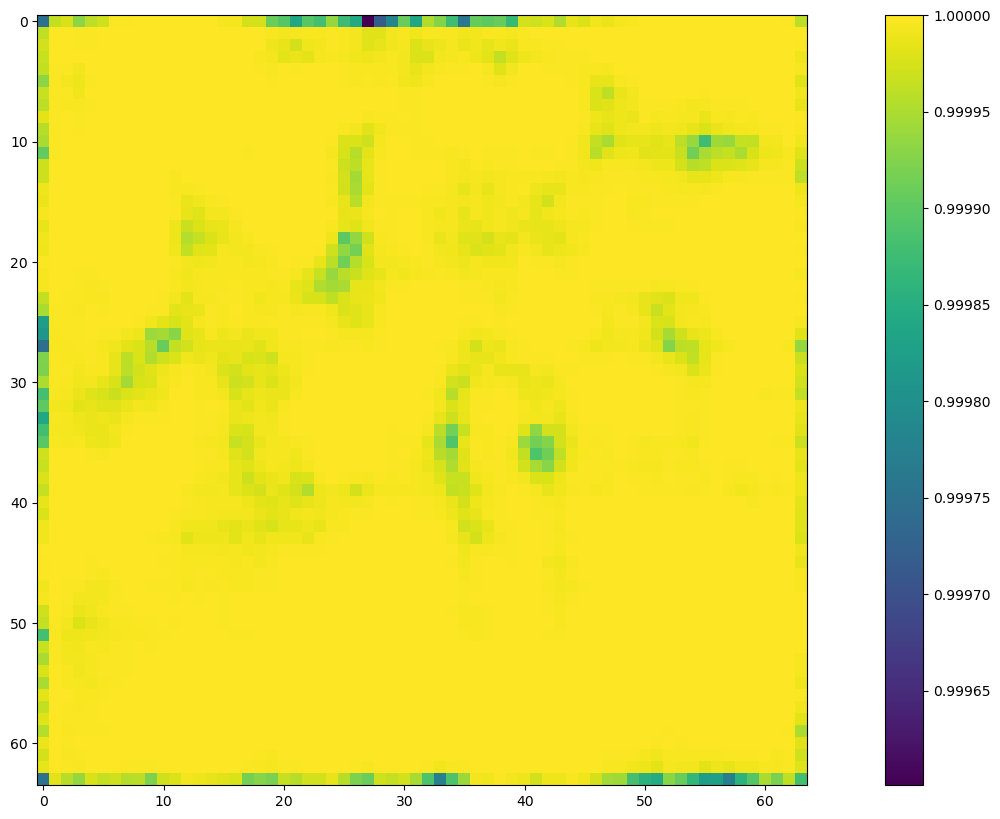

In [17]:
plt.imshow(yp_heat[0, 0])
plt.colorbar()

In [18]:
yp[0][:20]

tensor([[ 10.5887,  48.7982,   8.1093,  81.9585,   0.0000,   1.0000],
        [ 10.6692,  46.0560,   8.7828,  86.8332,   0.0000,   1.0000],
        [  9.7106,  38.3918,   9.0143,  85.9365,   0.0000,   1.0000],
        [  9.4169,  41.9931,   8.2762,  88.2140,   0.0000,   1.0000],
        [  8.9402,  27.1991,   8.2331,  59.6432,   0.0000,   1.0000],
        [  6.2646, 248.2019,  22.5115,  22.5811,   0.0000,   1.0000],
        [  9.6799,  31.0583,   9.4428,  69.8908,   0.0000,   1.0000],
        [  9.9907,  34.7439,   9.6298,  80.5154,   0.0000,   1.0000],
        [  4.8623, 229.5224,  26.2163,  70.2455,   0.0000,   1.0000],
        [  4.8819, 225.7512,  26.9957,  73.8369,   0.0000,   1.0000],
        [  6.5429, 218.4457,  27.1486,  75.7651,   0.0000,   1.0000],
        [  5.2754, 222.5561,  26.1439,  74.5354,   0.0000,   1.0000],
        [  6.2727, 238.0447,  25.9064,  65.2378,   0.0000,   1.0000],
        [  5.0030, 233.2908,  27.2421,  70.4091,   0.0000,   1.0000],
        [  6.6463, 2

In [19]:
y[:6]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


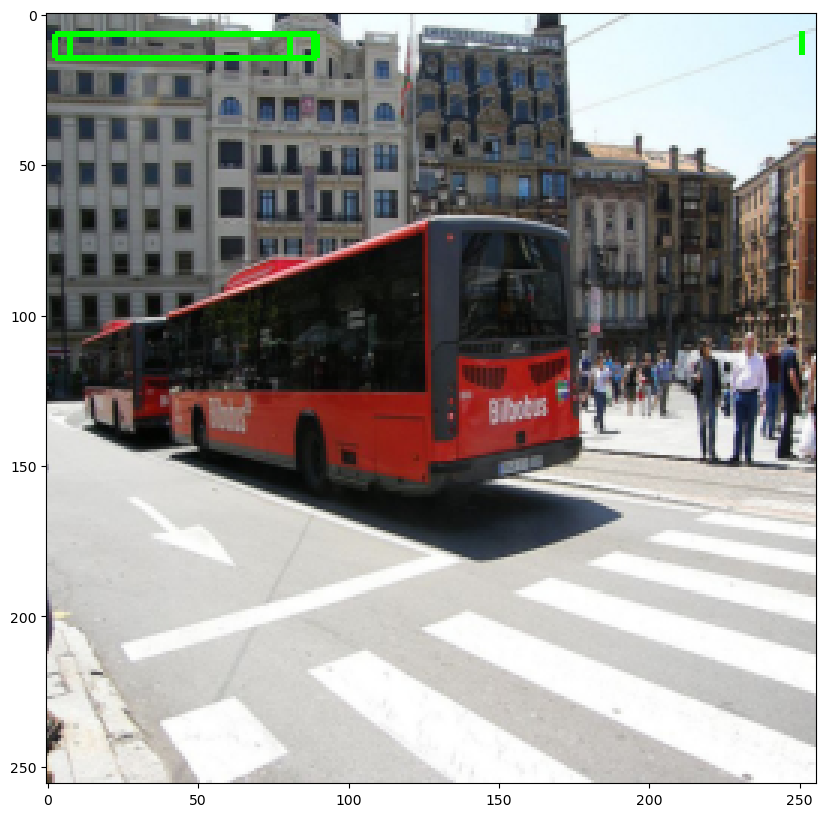

In [20]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
));